In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('Sentiment_Mental_health_dataset.csv')

In [3]:
df.head()

,statement,status
0,Anyone else have symptoms much improved after ...,Bipolar
1,"I basicaly do not exist, sure feels that way. ...",Suicidal
2,Finding a sense of self It's like one minute I...,Personality_disorder
3,Putting into words what were just tangles in m...,Anxiety
4,Anxiety makes me worry about my public image s...,Anxiety


In [4]:
df.shape

(26350, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26350 entries, 0 to 26349
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  26350 non-null  object
 1   status     26350 non-null  object
dtypes: object(2)
memory usage: 411.8+ KB


In [6]:
# checking null values
df.isnull().sum()

statement    0
status       0
dtype: int64

In [7]:
# checking null values
df.duplicated().sum()

np.int64(17)

In [8]:
print(df[df.duplicated()])

                                               statement                status
2124   I’m not one to post like this but I don’t know...              Suicidal
2644                                         That is all              Suicidal
7158   it’s been such a long journey with trial and e...  Personality_disorder
10465  As it is highly connected that traumas (especc...  Personality_disorder
11541                                                  .              Suicidal
13878                                                  .              Suicidal
14938  I found out recently that the man I’ve been da...  Personality_disorder
17099  Researchers at Federation University are seeki...  Personality_disorder
19676  Hi guys, I’m looking for responses for my surv...                Stress
20847                                             Please              Suicidal
21336  Can I use heat pad to warm up the muscles befo...                Normal
21569                                        That is

In [9]:
# dropping the duplicates 

df.drop_duplicates(inplace=True) 

In [10]:
df['status'].value_counts()

status
Suicidal                5592
Anxiety                 4704
Normal                  4574
Depression              4111
Personality_disorder    2810
Bipolar                 2720
Stress                  1822
Name: count, dtype: int64

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

# keep important negation words
negation_words = {"not", "no", "nor", "never"}
stop_words = stop_words - negation_words

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # lowercase
    text = text.lower()                          # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)   # remove urls
    text = re.sub(r'\S+@\S+', '', text)          # remove emails
    text = re.sub(r'[^a-z\s]', '', text)         # remove numbers & special chars
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces

    # tokenize
    tokens = word_tokenize(text)

    # remove stopwords & lemmatize
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]

    return " ".join(tokens)

In [12]:
df['processed_text'] = df['statement'].apply(preprocess_text)

df[['statement', 'processed_text']].head()

,statement,processed_text
0,Anyone else have symptoms much improved after ...,anyone else symptom much improved leaving spou...
1,"I basicaly do not exist, sure feels that way. ...",basicaly not exist sure feel way no friend no ...
2,Finding a sense of self It's like one minute I...,finding sense self like one minute im one pers...
3,Putting into words what were just tangles in m...,putting word tangle brain chronic anxiety toda...
4,Anxiety makes me worry about my public image s...,anxiety make worry public image damn much im f...


In [13]:
## Encoding status 

mapping = {
    'Anxiety': 0,
    'Bipolar': 1,
    'Depression': 2,
    'Normal': 3,
    'Personality_disorder': 4,
    'Stress': 5,
    'Suicidal': 6
}

df['status_encoded'] = df['status'].map(mapping)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26333 entries, 0 to 26349
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   statement       26333 non-null  object
 1   status          26333 non-null  object
 2   processed_text  26333 non-null  object
 3   status_encoded  26333 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
                lowercase=True,
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.8,
                max_features=10000,
                sublinear_tf=True,
            )
        

In [16]:
X = vectorizer.fit_transform(df['processed_text'])
y = df['status_encoded']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [18]:
X_train.shape, y_train.shape

((21066, 10000), (21066,))

In [19]:
X_test.shape, y_test.shape

((5267, 10000), (5267,))

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [22]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       941
           1       0.82      0.71      0.76       544
           2       0.56      0.55      0.55       822
           3       0.97      0.99      0.98       915
           4       0.75      0.75      0.75       562
           5       0.70      0.69      0.70       364
           6       0.69      0.75      0.72      1119

    accuracy                           0.76      5267
   macro avg       0.75      0.74      0.75      5267
weighted avg       0.76      0.76      0.76      5267



In [23]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.169822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392341
[LightGBM] [Info] Number of data points in the train set: 21066, number of used features: 9904
[LightGBM] [Info] Start training from score -1.722444
[LightGBM] [Info] Start training from score -2.270172
[LightGBM] [Info] Start training from score -1.857077
[LightGBM] [Info] Start training from score -1.750470
[LightGBM] [Info] Start training from score -2.237619
[LightGBM] [Info] Start training from score -2.670595
[LightGBM] [Info] Start training from score -1.549601


D:\AppData\AppMain\Python 3.11\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.78      0.79      0.79       941
           1       0.86      0.71      0.78       544
           2       0.53      0.55      0.54       822
           3       0.97      0.97      0.97       915
           4       0.83      0.73      0.78       562
           5       0.75      0.63      0.69       364
           6       0.66      0.77      0.71      1119

    accuracy                           0.75      5267
   macro avg       0.77      0.73      0.75      5267
weighted avg       0.76      0.75      0.75      5267



In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Support Vector Classifier
svc_model = SVC(
    kernel='linear',        # linear kernel works well for text
    class_weight='balanced',# handle imbalanced classes
    probability=True        # enable probability estimates
)

svc_model.fit(X_train, y_train)

# Evaluate
y_pred = svc_model.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Assume X (TF-IDF features) and y (encoded labels) are ready
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Convert sparse TF-IDF to dense for Keras
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Build model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train_dense, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Evaluate
loss, acc = model.evaluate(X_test_dense, y_test)
print("Test Accuracy:", acc)


D:\AppData\AppMain\Python 3.11\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.6705 - loss: 0.9309 - val_accuracy: 0.7584 - val_loss: 0.6726
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.8775 - loss: 0.3629 - val_accuracy: 0.7371 - val_loss: 0.7405
Epoch 3/10
135/297 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9635 - loss: 0.1389

# 1: Word2Vec / GloVe (Static Embeddings)

In [ ]:
import gensim.downloader as api
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load pretrained GloVe embeddings (100 dimensions)
glove_model = api.load("glove-wiki-gigaword-100")

def sentence_vector(sentence):
    words = sentence.split()
    vectors = [glove_model[w] for w in words if w in glove_model]
    if len(vectors) == 0:
        return np.zeros(100)
    return np.mean(vectors, axis=0)

# Convert dataset
X = np.array([sentence_vector(text) for text in df['final_text']])
y = df['status_encoded']

# Build simple neural net
model = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.1)


# 2: BERT Embeddings (Contextual)

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def bert_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # Mean pooling
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Convert dataset
X = np.vstack([bert_sentence_embedding(text) for text in df['final_text']])
y = df['status_encoded']

# Neural net on top of BERT embeddings
model = Sequential([
    Dense(256, activation='relu', input_shape=(768,)),  # DistilBERT gives 768-dim vectors
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=5, batch_size=32, validation_split=0.1)


In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, class_weight='balanced')

In [24]:
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

# Evaluation

Validation classification report (TF-IDF + LogisticRegression):
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       941
           1       0.80      0.73      0.76       544
           2       0.57      0.60      0.59       822
           3       0.98      0.97      0.97       915
           4       0.80      0.75      0.77       562
           5       0.72      0.81      0.76       364
           6       0.72      0.77      0.75      1119

    accuracy                           0.78      5267
   macro avg       0.78      0.77      0.77      5267
weighted avg       0.78      0.78      0.78      5267



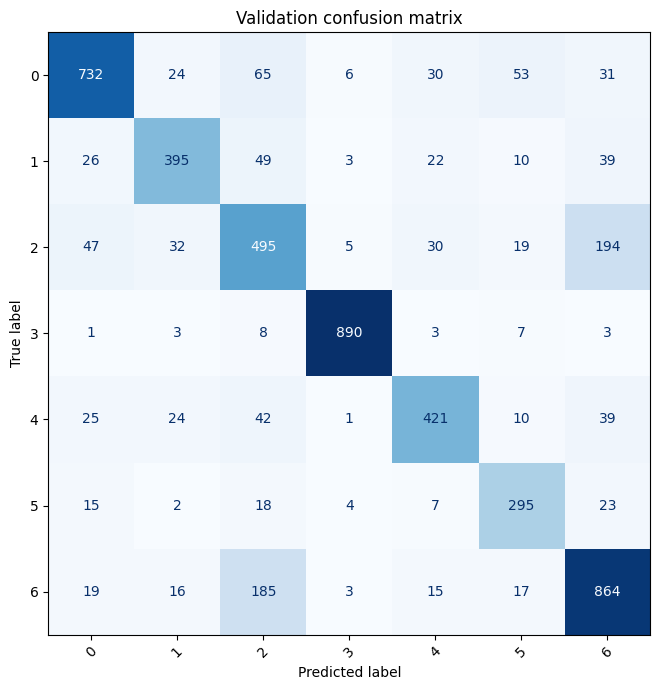

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on validation
y_pred = model.predict(X_test)

print("Validation classification report (TF-IDF + LogisticRegression):")
print(classification_report(y_test, y_pred))

# Confusion matrix
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(9, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45, colorbar=False)
ax.set_title("Validation confusion matrix")
plt.tight_layout()
plt.show()

In [33]:
# Save the model

import joblib

# Save trained classifier
joblib.dump(model, "mental_health_model.pkl")

# Save fitted TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [27]:
new_text = ["I feel hopeless and can't sleep at night"]

# Transform using the same vectorizer
X_new = vectorizer.transform(new_text)

# Predict class
predicted_status = model.predict(X_new)
print("Predicted status:", predicted_status[0])

# If you want probabilities for all 7 classes
proba = model.predict_proba(X_new)
print("Class probabilities:", proba)

Predicted status: 2
Class probabilities: [[0.10281077 0.12367095 0.31339405 0.03855407 0.04561089 0.17001857
  0.20594071]]


In [29]:
# Example new input
new_text = "I feel very anxious and can't sleep."

# Preprocess
clean_text = preprocess_text(new_text)

# Transform
X_new = vectorizer.transform([clean_text])

pred_encoded = model.predict(X_new)[0]


In [32]:
# Reverse mapping
reverse_mapping = {v: k for k, v in mapping.items()}

# Decode prediction
pred_label = reverse_mapping[pred_encoded]
print("Predicted category:", pred_label)

# probabilities for all 7 classes
proba = model.predict_proba(X_new)
print("Class probabilities:", proba)

Predicted category: Anxiety
Class probabilities: [[0.82910018 0.01574122 0.02308294 0.00497176 0.00992927 0.10232781
  0.01484682]]


In [34]:
# Load them back
loaded_model = joblib.load("mental_health_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Example new text
new_text = "I feel very anxious and can't sleep."

# Preprocess (same as training)
clean_text = preprocess_text(new_text)

# Transform with loaded vectorizer
X_new = loaded_vectorizer.transform([clean_text])

# Predict
pred_encoded = loaded_model.predict(X_new)[0]

# Decode back to category
reverse_mapping = {v: k for k, v in mapping.items()}
print("Predicted category:", reverse_mapping[pred_encoded])


Predicted category: Anxiety
